In [3]:
## It appears that ElasticNet() is a model that can perform both Ridge and Lasso regression by changing the l1_ratio parameter.

In [4]:
## This Notebook will Utilize Best Subset Selection on the Hitters Dataset
## imports
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import statsmodels.api as sm
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise,
sklearn_selected,
sklearn_selection_path)
import matplotlib.pyplot as plt



In [5]:
## Load Hitters Data from ISLP package
hitters = load_data('Hitters')
np.isnan(hitters['Salary']).sum()

## Get Categorical Variables
#print(hitters.dtypes)
categorical_cols = hitters.select_dtypes(include=['category']).columns.tolist()
#print(categorical_cols)

## Drop 59 Null Rows
hitters = hitters.dropna()

## One Hot Encode Categorical Columns
one_hot_hitters = pd.get_dummies(hitters, drop_first=True)

In [6]:
X = one_hot_hitters.drop(columns=['Salary'])
y = one_hot_hitters.Salary


## Scale the Variables
scaler = StandardScaler()
s_hitters = scaler.fit_transform(one_hot_hitters.drop(columns=['Salary']))
display(s_hitters)

lambdas = 10**np.linspace(8, -2, 100) / y.std()

array([[-0.6029005 , -0.59567545, -0.5285512 , ...,  1.05875764,
         0.98116592,  1.07505242],
       [ 0.51254171,  0.49225957,  0.72996619, ..., -0.94450322,
         0.98116592, -0.9301872 ],
       [ 0.62816682,  0.73648988,  0.95878753, ...,  1.05875764,
        -1.01919561,  1.07505242],
       ...,
       [ 0.48533581,  0.40344855, -0.98619389, ..., -0.94450322,
         0.98116592, -0.9301872 ],
       [ 1.15188054,  0.80309815, -0.29972986, ..., -0.94450322,
        -1.01919561, -0.9301872 ],
       [ 1.54636621,  1.38036979, -0.29972986, ..., -0.94450322,
         0.98116592, -0.9301872 ]])

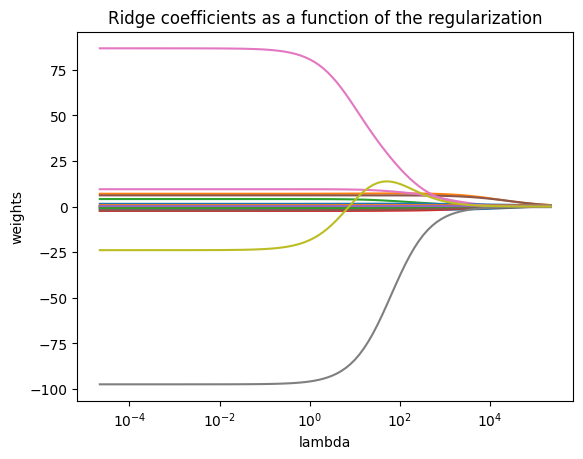

In [7]:
## Regularization "path" here refers to the coefficients for each model along the scale of lambda. We create a grid of values for lambda ranging from 10^8 to 10^-2 scaled by the standard deviation of y to cover the full range of scenarios from the null model containing only an intercept to the OLS fit

## Here, we plot the coefficients as a function of lambda to get a sense of how the coefficients react to the shrinkage penalty

lambdas = 10**np.linspace(8, -2, 100) / y.std()

coefs = []
for l in lambdas:
    ridge = skl.Ridge(alpha=l, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

ax = plt.gca()

ax.plot(lambdas, coefs)
ax.set_xscale("log")
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("lambda")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

## Estimating Test Error of Ridge Regression

In [8]:
## Will First Use the Validation Set Approach with an arbitrary alpha

validation = skm.ShuffleSplit(
    n_splits=1,
    test_size=0.5,
    random_state=0
)

ridge.alpha = 0.01
results = skm.cross_validate(
    ridge,
    X,
    y,
    scoring='neg_mean_squared_error',
    cv=validation
)

print(-results['test_score'])

[134430.44386319]


In [9]:
## If we had simply fit with just an intercept, we would have predicted each test observation using the mean of the training observations.
## The same can be achieved by using a very large value of lambda

## When the Data is standardized, there is no need to fit an intercept column, as is done in the book. This is why our Test MSE estimates are very far apart here.

ridge.alpha = 1e10
results = skm.cross_validate(
    ridge,
    X,
    y,
    scoring='neg_mean_squared_error',
    cv=validation
)

print(-results['test_score'])

[431525.36585977]


In [10]:
## Using validation set approach to choose an optimal lambda
## GridSearch allows exhaustive grid search to help

pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('ridge', ridge)
])

pipe.fit(X,y)

param_grid = {'ridge__alpha': lambdas}

grid = skm.GridSearchCV(
    pipe,
    param_grid,
    cv=validation,
    scoring='neg_mean_squared_error'
    )

grid.fit(X, y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 Ridge(alpha=0.6168131627521554, fit_intercept=False))])

In [11]:
## Using cross-validation set approach to choose an optimal lambda
## GridSearch allows exhaustive grid search to help

k = 5
kfold = skm.KFold(
    k,
    random_state=0,
    shuffle=True
)

param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(
    pipe,
    param_grid,
    cv=kfold,
    scoring='neg_mean_squared_error'
    )

grid.fit(X, y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 Ridge(alpha=1.9733500817538403, fit_intercept=False))])

Text(0, 0.5, 'Cross-validated MSE')

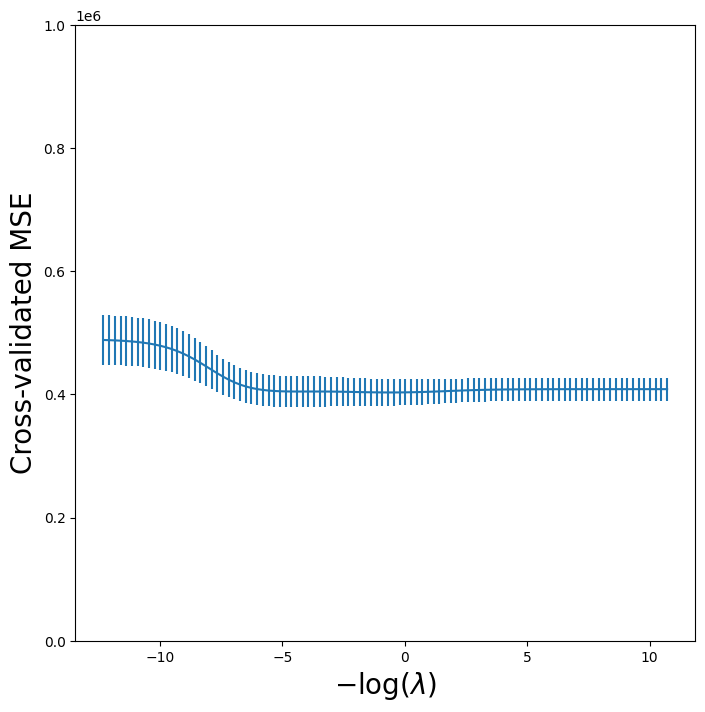

In [15]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),

-grid.cv_results_['mean_test_score'],
yerr=grid.cv_results_['std_test_score'] / np.sqrt(k))

ax.set_ylim([0,1000000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

## Evaluating Test Error of Cross-Validated Ridge

In [19]:
## Do an initial split of the data before CV so that you can use CV to select your tuning parameter, then test on the unseen data

outer_valid = skm.ShuffleSplit(
    n_splits=1,
    test_size=0.25,
    random_state=1
    )

inner_cv = skm.KFold(
    n_splits=5,
    shuffle=True,
    random_state=2
    )

ridge = skl.RidgeCV(fit_intercept=False, cv=inner_cv)

pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('ridge', ridge)
])

results = skm.cross_validate(pipe,
X,
y,
cv=outer_valid,
scoring='neg_mean_squared_error')

-results['test_score']

array([440016.51392698])

## The Lasso

In [ ]:
## We now fit the Hitters data to a Lasso model

In [21]:
lassoCV = skl.LassoCV(n_alphas=100, cv=kfold)

pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('lasso', lassoCV)
])

pipe.fit(X, y)

tuned_lasso = pipe.named_steps['lasso']
tuned_lasso.alpha_

3.1472370031649866

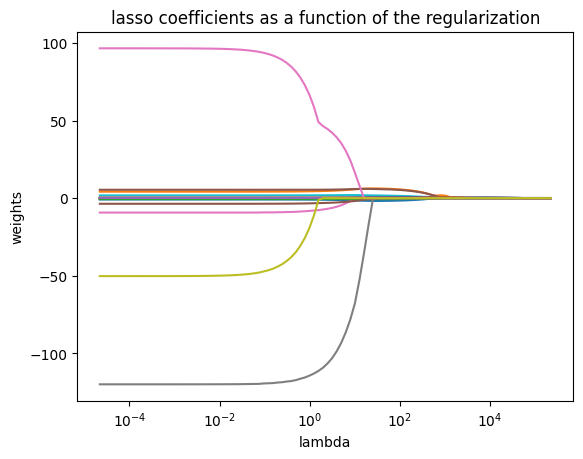

In [28]:
lambdas = 10**np.linspace(8, -2, 100) / y.std()

coefs = []
for l in lambdas:
    lasso = skl.Lasso(alpha=l, fit_intercept=False, tol=0.1)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(lambdas, coefs)
ax.set_xscale("log")
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("lambda")
plt.ylabel("weights")
plt.title("lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show()